In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.signal import lfilter
from IPython import display

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras import activations
from keras.layers import Activation, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Softmax, Dropout, BatchNormalization

In [35]:
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
from preprocessing import import_preprocessed_data, add_empties_column, calculate_empties
from train import create_windows_smoothed, create_train_val_test_split
from predict import predict_values, predict_values_with_gradient

In [24]:
%load_ext autoreload
%autoreload 2
%aimport preprocessing
%aimport train
%aimport predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dfs_c_0, dfs_c_1, dfs_c_2, dfs_c_0_grouped, dfs_c_1_grouped, dfs_c_2_grouped = import_preprocessed_data() # import all data

In [6]:
# create lstm input
X,y = create_windows_smoothed(dfs_c_0, 40, 1, 20)
#Split data into train & test set & validation set 
X_train, y_train, X_test, y_test, X_val, y_val = create_train_val_test_split(X,y)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(3167, 40, 1)
(3167, 1)
(792, 40, 1)
(792, 1)
(990, 40, 1)
(990, 1)


In [7]:
# build lstm 
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape= (40, 1)))
model.add(LSTM(200))
model.add(Dense(1, activation='relu'))

#optimizer = optimizers.Adam(clipvalue=0.5)
adam = tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=adam, loss='mse',metrics=['mean_absolute_error'])

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), verbose=1, shuffle=True)

The model was trained on google colab with the code written above. We simply import the model here.

In [8]:
from keras.models import load_model
model = load_model('../models/c0_lstm.h5')

The following will show what the training looked like

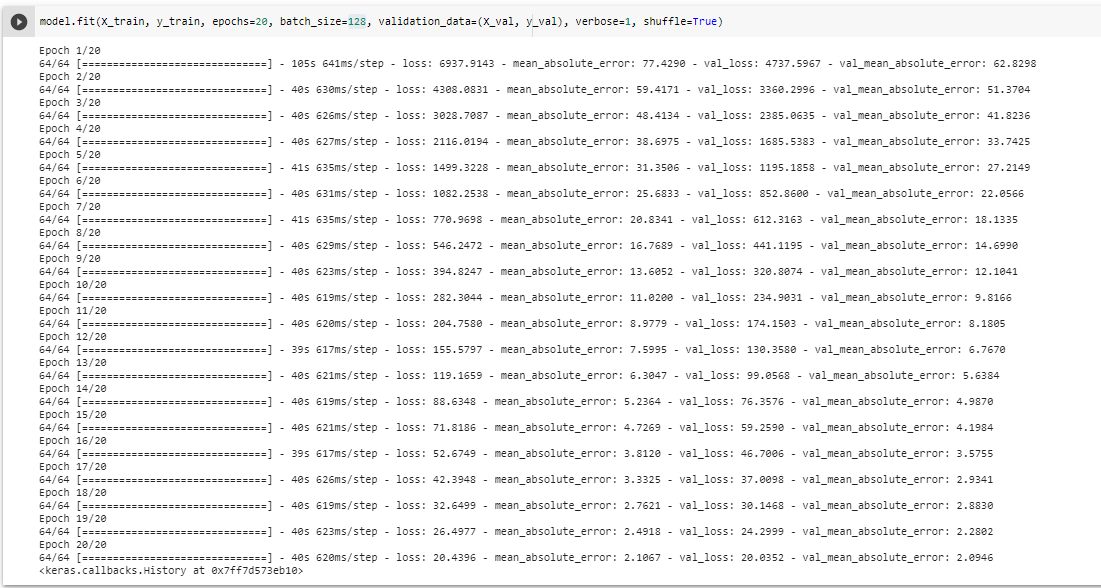

In [15]:
display.Image("../notebooks/Training_LSTM_c0.png")

In [9]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 40, 200)           161600    
_________________________________________________________________
lstm_21 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [31]:
# use one validation set as starting point for the prediction
initial_set = X_val[0]
initial_set

array([[75.4       ],
       [74.86666667],
       [74.33333333],
       [73.8       ],
       [73.4       ],
       [72.6       ],
       [72.13333333],
       [71.6       ],
       [71.2       ],
       [70.86666667],
       [70.66666667],
       [70.26666667],
       [69.8       ],
       [69.33333333],
       [69.        ],
       [68.66666667],
       [68.33333333],
       [68.        ],
       [67.66666667],
       [67.33333333],
       [67.13333333],
       [66.86666667],
       [66.4       ],
       [65.73333333],
       [65.13333333],
       [64.46666667],
       [63.73333333],
       [63.        ],
       [62.4       ],
       [61.93333333],
       [61.4       ],
       [60.86666667],
       [60.33333333],
       [59.8       ],
       [59.33333333],
       [59.13333333],
       [58.66666667],
       [58.26666667],
       [57.86666667],
       [57.46666667]])

In [32]:
result = predict_values(model, initial_set, 500, 40) # predict 500 values 

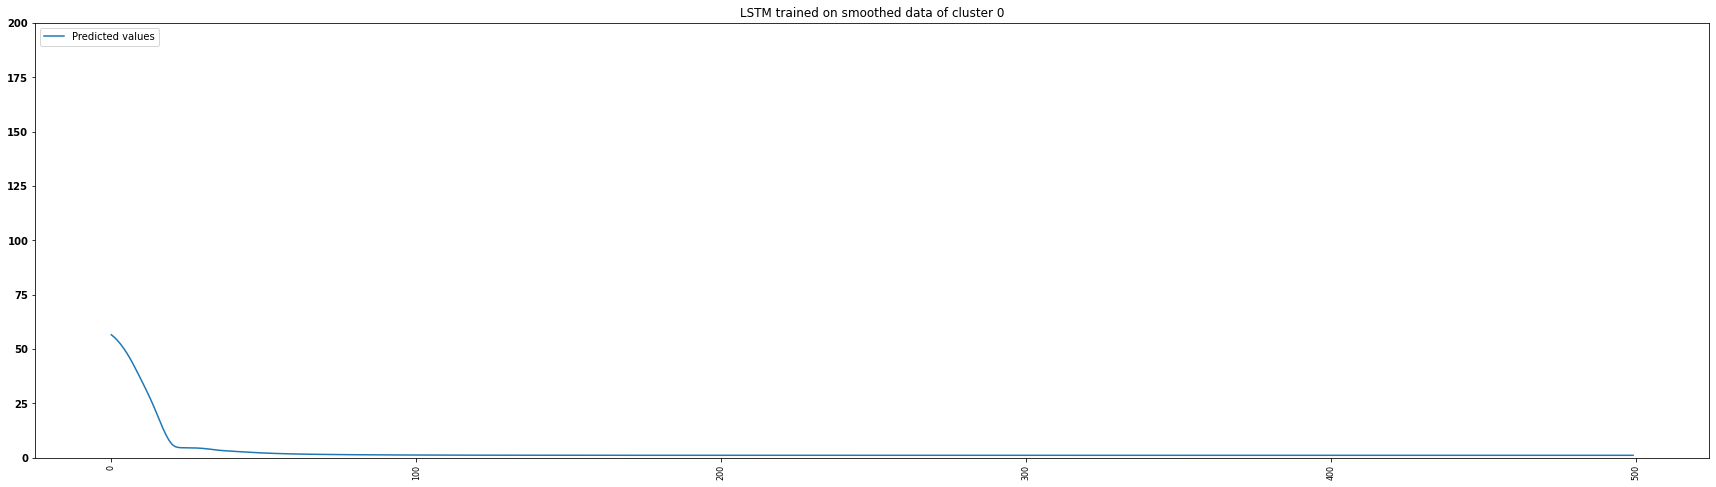

In [33]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("LSTM trained on smoothed data of cluster 0")

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(result)

plt.legend(['Predicted values'], loc='upper left')

plt.show()

As can be seen the model learns the gradient of the values.

In [34]:
# create an initial set that mimics an empty container
initial_set_2 = []
for i in range(1, 41, 1):
  initial_set_2.append(140)
initial_set_2 = np.array(initial_set_2)
initial = initial_set_2
initial_set_2

array([140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
       140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
       140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
       140])

In [37]:
result2 = predict_values_with_gradient(model, initial_set, initial, 500, 40) # predict 500 values with reset of the values when Height is near 0

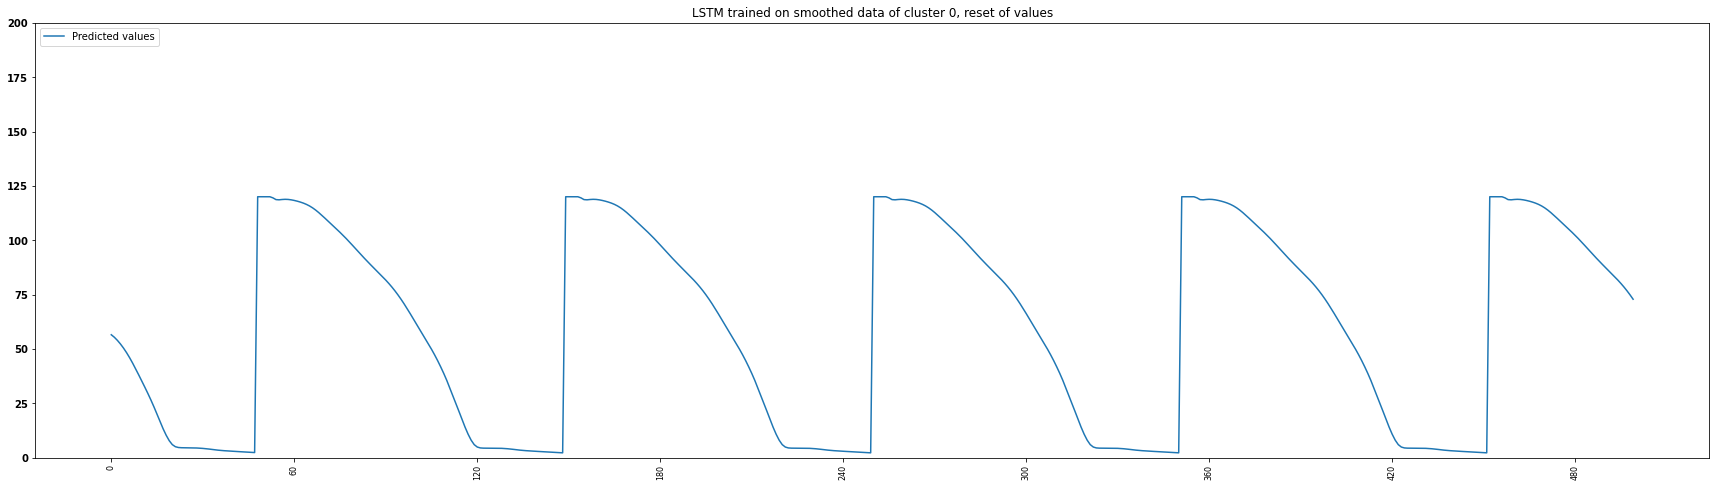

In [40]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("LSTM trained on smoothed data of cluster 0, reset of values")

plt.xticks(np.arange(0, 500, step=60), fontsize=8, rotation=90, )
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(result2)
#plt.plot(dfs_c_0[0]['inter_pol'])

plt.legend(['Predicted values'], loc='upper left')

plt.show()

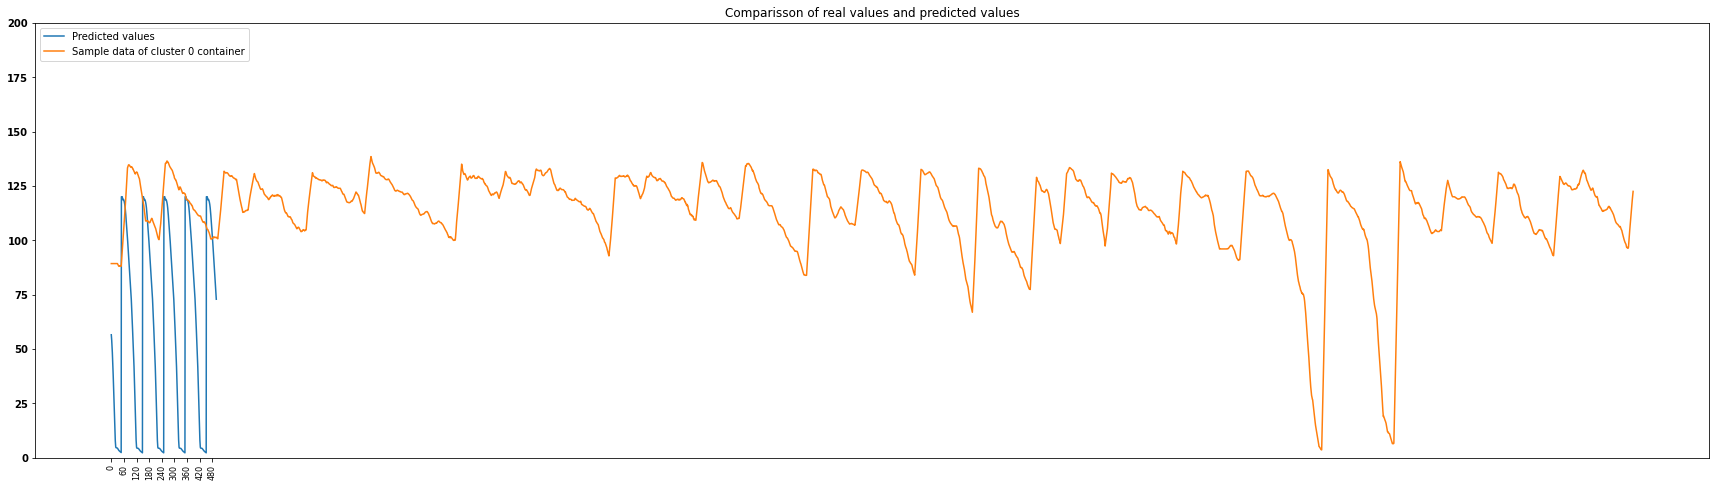

In [41]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("Comparisson of real values and predicted values")

plt.xticks(np.arange(0, 500, step=60), fontsize=8, rotation=90, )
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(result2)
plt.plot(dfs_c_0[0]['inter_pol'])

plt.legend(['Predicted values', 'Sample data of cluster 0 container'], loc='upper left')

plt.show()

As can be seen, the model does not learn an appropriate gradient when using the data of every hour. In another approach we use the data for every day and achieve better results.